In [1]:
# GPU kullanıyoruz mu test edelim
!nvidia-smi

Sun Jul 18 06:27:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## TensorFlow Hub ile Transfer Learning: Verilerin %10'u ile Harika Sonuçlar Elde Etme

"Elbette bir başkası bu iş için doğru modeli yapmak için zaman harcadı..." diye düşünüyorsanız, şanslısınız demektir.

Derin öğrenmeyi kullanmak isteyeceğiniz sorunların çoğu için, muhtemelen çalışan bir model zaten mevcuttur. Ve iyi haber şu ki, çoğuna TensorFlow Hub'dan erişebilirsiniz. [TensorFlow Hub](https://tfhub.dev/), mevcut model bileşenleri için bir havuzdur. Bir URL kadar az olan tam eğitimli bir modeli içe aktarabilmenizi ve kullanabilmenizi sağlar.

Şimdi, size transfer öğrenmenin gücünü gerçekten göstermek istiyorum.

Bunu yapmak için, orijinal verinin yalnızca %10'u ile, yani 10 kat daha az veri ile şimdiye kadar elde ettiğimiz en iyi modelimizin elde ettiği sonuçların çoğunu (veya daha iyisini) elde edebileceğimizi söylesem ne olur?

Bu mantıksız görünüyor değil mi?

Bir yemek resminin nasıl göründüğüne dair daha fazla örneğin daha iyi sonuçlara yol açtığını düşünmez miydiniz?

Ve genel olarak, daha fazla verinin daha iyi sonuçlara yol açtığını düşünüyorsanız haklısınız.

Ancak, ya daha fazla veriye sahip değilseniz? Sınıf başına 750 görsel yerine, sınıf başına 75 görseliniz olsaydı ne olurdu?

Belirli bir sınıfa ait 675 resim daha toplamak uzun zaman alabilir.

İşte transfer öğreniminin bir başka önemli faydası da burada devreye giriyor.

Aktarım öğrenimi genellikle daha az veriyle harika sonuçlar elde etmenizi sağlar.

Kullanmakta olduğumuz verilerin bir alt kümesini, yani 10_food_classes veri kümesindeki eğitim verilerinin %10'unu indirelim ve bunu bir yemek görüntüsü sınıflandırıcısını eğitmek için kullanalım.

<img src="https://cdn-images-1.medium.com/max/602/1*NF1_eYZrV5fj0_EICLKytw.jpeg" />

## Veriyi Azaltma

In [10]:
# verisetini içeriye aktarma
import zipfile

!gdown --id 1EJHNCG19hJG6XwIFxt2rpah-Q1Ikrbxw
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

Downloading...
From: https://drive.google.com/uc?id=1EJHNCG19hJG6XwIFxt2rpah-Q1Ikrbxw
To: /content/10_food_classes_10_percent.zip
169MB [00:01, 158MB/s]


In [11]:
# Her klasörde kaç resim var?
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"'{dirpath}' klasöründe {len(filenames)} veri var.")

'10_food_classes_10_percent' klasöründe 0 veri var.
'10_food_classes_10_percent/test' klasöründe 0 veri var.
'10_food_classes_10_percent/test/hamburger' klasöründe 250 veri var.
'10_food_classes_10_percent/test/grilled_salmon' klasöründe 250 veri var.
'10_food_classes_10_percent/test/pizza' klasöründe 250 veri var.
'10_food_classes_10_percent/test/chicken_curry' klasöründe 250 veri var.
'10_food_classes_10_percent/test/sushi' klasöründe 250 veri var.
'10_food_classes_10_percent/test/ice_cream' klasöründe 250 veri var.
'10_food_classes_10_percent/test/fried_rice' klasöründe 250 veri var.
'10_food_classes_10_percent/test/chicken_wings' klasöründe 250 veri var.
'10_food_classes_10_percent/test/steak' klasöründe 250 veri var.
'10_food_classes_10_percent/test/ramen' klasöründe 250 veri var.
'10_food_classes_10_percent/train' klasöründe 0 veri var.
'10_food_classes_10_percent/train/hamburger' klasöründe 75 veri var.
'10_food_classes_10_percent/train/grilled_salmon' klasöründe 75 veri var.
'1

Eğitim verilerinin her birinin artık 750 görüntü yerine 75 görüntüye sahip olduğuna dikkat edin. Bu, transfer öğreniminin daha az etiketli görüntülerle ne kadar iyi performans gösterebileceğini göstermenin anahtarıdır.

Test dizinleri hala aynı miktarda görüntüye sahip. Bu, daha az veri üzerinde eğitim yapacağımız, ancak modellerimizi aynı miktarda test verisi üzerinde değerlendireceğimiz anlamına geliyor.

## Verileri Hazırlama

Verileri indirdik, şimdi `imageDataGenerator` sınıfını ve `flow_from_directory` yöntemini kullanarak resimlerimizi yükleyelim.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training resimleri:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing resimleri:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training resimleri:
Found 750 images belonging to 10 classes.
Testing resimleri:
Found 2500 images belonging to 10 classes.


Mükemmel! Verileri yüklediğimizde, 10 sınıfa (sınıf başına 75) ait eğitim veri setinde 750 görüntü ve 10 sınıfa ait (sınıf başına 250) test setinde 2500 görüntü olduğunu görüyoruz.

## Callback İşlevlerini Ayarlama 

Bir model oluşturmadan önce, aşina olacağımız önemli bir kavram var çünkü gelecekteki model oluşturma deneylerimizde kilit bir rol oynayacak.

Ve bu kavram Callback.

[Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks), eğitim sırasında veya sonrasında gerçekleştirilmek üzere modellerinize ekleyebileceğiniz ekstra işlevlerdir. En popüler callback'lerden bazıları şunlardır:
- [**TensorBoard ile modeli izleme**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)<br>
Birden fazla modelin performansını günlüğe kaydedin ve ardından bu modelleri TensorBoard'da (sinir ağı parametrelerini incelemek için bir gösterge panosu) görsel bir şekilde görüntüleyin ve karşılaştırın. Verileriniz üzerinde farklı modellerin sonuçlarını karşılaştırmanıza yardımcı olur.
- [**Model Checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)<br>
Modelinizi eğitirken kaydedin, böylece gerekirse eğitimi durdurabilir ve kaldığınız yerden devam etmek için geri dönebilirsiniz. Eğitim uzun sürüyorsa ve bir oturuşta yapılamıyorsa faydalıdır.
- [**Early Stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)<br> 
Model eğitiminizi isteğe bağlı bir süre için bırakın ve gelişme sona erdiğinde eğitimi otomatik olarak durdurmasını sağlayın. Büyük bir veri kümeniz olduğunda ve eğitimin ne kadar süreceğini bilmediğinizde faydalıdır.

Bunların her birini inceleyeceğiz, ancak bu defter için TensorBoard geri aramasının nasıl kullanılabileceğini göreceğiz.

TensorBoard geri çağrısına `tf.keras.callbacks.TensorBoard()` kullanılarak erişilebilir. Ana işlevi, bir modelin eğitim performans ölçümlerini belirtilen bir log_dir'e kaydetmektir.

Varsayılan olarak, günlükler `update_freq='epoch'` parametresi kullanılarak her epoch'ta kaydedilir. Bu iyi bir varsayılandır, çünkü model performansının izlenmesi sıklıkla model eğitimini yavaşlatabilir.

TensorBoard kullanarak modelleme deneylerimizi izlemek için, bizim için bir TensorBoard geri çağrısı oluşturan bir fonksiyon oluşturalım.

> 🔑 Not: Bir TensorBoard geri çağrısı oluşturmak için bir fonksiyon yaratırız çünkü daha sonra göreceğimiz gibi, her model kendi TensorBoard geri çağırma örneğine ihtiyaç duyar (böylece fonksiyon her çalıştırıldığında yeni bir tane yaratacaktır).

In [13]:
# Tensorboard callback işlevini oluşturma
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"TensorBoard günlük dosyalarını kaydetme: {log_dir}")
  return tensorboard_callback

Birden fazla modeli çalıştırmanız muhtemel olduğundan, bunları bir şekilde takip edebilmek iyi bir fikirdir.

Bizim durumumuzda, fonksiyonumuz bir modelin performans günlüklerini `[dir_name]/[experiment_name]/[current_timestamp]` adlı bir dizine kaydeder, burada:

- `dir_name` genel günlükler dizinidir
- `experiment_name` belirli bir modeldir
- `current_timestamp` Python'un datetime.datetime().now() değerine dayalı olarak deneyin başladığı zamandır

> 🔑 Not: Kullanım durumunuza bağlı olarak, yukarıdaki deneme amaçlı izleme adlandırma yöntemi işe yarayabilir veya daha spesifik bir şeye ihtiyacınız olabilir. İyi haber şu ki, TensorBoard geri araması, onları nerede izleyeceğinizi belirttiğiniz sürece modelleme günlüklerini izlemeyi kolaylaştırır. Böylece, deneylerinizi nasıl adlandırdığınız konusunda istediğiniz kadar yaratıcı olabilirsiniz, sadece sizin veya ekibinizin onları anlayabildiğinden emin olun.

## TensorFlow Hub Kullanarak Bir Model Oluşturma

Geçmişte, sıfırdan katman katman kendi modellerimizi oluşturmak için TensorFlow'u kullandık. Şimdi benzer bir işlem yapacağız, ancak modelimizin katmanlarının çoğu TensorFlow Hub'dan gelecek.

Aslında, TensorFlow Hub'dan iki model kullanacağız:

- **ResNetV2**<br>
2016'dan itibaren son teknoloji bir bilgisayarlı görü modeli mimarisi.
- **EfficientNet**<br>
2019'dan itibaren son teknoloji bir bilgisayarlı görü mimarisi.

Son teknoloji, bir noktada, bu modellerin her ikisinin de bilgisayarla görme kıyaslamalarının altın standardı olan ImageNet'te (ILSVRC-2012-CLS) en düşük hata oranını elde ettiği anlamına gelir.

Merak ediyor olabilirsiniz, bu modelleri TensorFlow Hub'da nasıl buluyorsunuz?

İşte attığım adımlar:

1. tfhub.dev'e gidin.
2. Sorunlu etki alanınızı seçin, ör. "Görüntü" (yemek resimleri kullanıyoruz).
3. Bizim durumumuzda TF2 olan TF sürümünüzü seçin.
4. Üzerinde çalıştığınız sorun dışındaki tüm "Problem Domain" filtrelerini kaldırın.
  - **Not:** "Image feature vector" hemen hemen her problemin yanında kullanılabilir, buna birazdan geleceğiz.
Listelenen modeller, probleminiz için potansiyel olarak kullanılabilecek tüm modellerdir.

> 🤔 **Soru:**<br> Görüntü sınıflandırma modelleri için birçok seçenek görüyorum, hangisinin en iyi olduğunu nasıl bileceğim?

En son modellerin bir listesini [paperswithcode.com](https://www.paperswithcode.com/)'da görebilirsiniz; bu kaynak, raporladıkları bulgular için kod uygulamalarına sahip en son derin öğrenme makalesi sonuçlarını toplamak için bir kaynaktır.

Görüntülerle çalıştığımız için hedefimiz [ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet)'te en iyi performansı gösteren modeller.

Muhtemelen kodlu kağıtlarda listelenen model mimarilerinin tümünün TensorFlow Hub'da görünmediğini göreceksiniz. Ve bu sorun değil, hala mevcut olanı kullanabiliriz.

6. TensorFlow Hub'da Mimari sekmesini seçin ve mimari adlarından oluşan bir açılır menünün göründüğünü göreceksiniz.
  - Buradaki temel kural genellikle, daha büyük sayılara sahip isimler daha iyi performans gösteren modeller anlamına gelir. Örneğin, EfficientNetB4, EfficientNetB0'dan daha iyi performans gösterir.
    - Bununla birlikte, daha büyük sayılarla yapılan ödünleşim, hesaplamanın daha uzun sürdüğü anlamına gelebilir.

7. EfficientNetB0'ı seçin ve aşağıdakine benzer bir şey görmelisiniz:

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-tensorflow-hub-efficientnetb0.png" />

8. ["efficientnet/b0/feature-vector"](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) başlığına tıklamak bizi "URL'yi kopyala" yazan bir buton içeren bir sayfaya getiriyor. Bu URL, EfficientNetB0'ın gücünden yararlanmak için kullanabileceğimiz şeydir.
  - URL'yi kopyalamak size şöyle bir şey vermelidir: https://tfhub.dev/tensorflow/quality/b0/feature-vector/1

> 🤔 Soru: Görüntü sınıflandırması yaptığımızı sanıyordum, neden sınıflandırma değil de özellik vektörünü seçiyoruz?

Harika gözlem. Bu, özellik çıkarma ve ince ayar gibi farklı aktarım öğrenme türlerinin devreye girdiği yerdir.

1. **"As is" transfer öğrenme**, önceden eğitilmiş bir modeli olduğu gibi alıp herhangi bir değişiklik yapmadan görevinize uyguladığınız zamandır.

  - Örneğin, birçok bilgisayarlı görü modeli, 1000 farklı görüntü sınıfını içeren ImageNet veri kümesi üzerinde önceden eğitilmiştir. Bu, bu modele tek bir görüntünün geçirilmesinin 1000 farklı tahmin olasılığı değeri (her sınıf için 1) üreteceği anlamına gelir.

    - Sınıflandırmak istediğiniz 1000 görüntü sınıfınız varsa ve bunların tümü ImageNet sınıflarıyla aynıysa bu yararlıdır, ancak yalnızca küçük bir sınıf alt kümesini (10 farklı tür gibi) sınıflandırmak istiyorsanız bu yararlı değildir. TensorFlow Hub'da adlarında `/classification` bulunan modeller bu tür bir işlevsellik sağlar.

2. **Özellik çıkarma transferi öğrenimi**, önceden eğitilmiş bir modelin öğrendiği temel kalıpları (ağırlıklar da denir) aldığınızda ve çıktılarını probleminize daha uygun olacak şekilde ayarladığınızda gerçekleşir.

  - Örneğin, kullandığınız önceden eğitilmiş modelin 236 farklı katmanı olduğunu varsayalım (EfficientNetB0'ın 236 katmanı vardır), ancak ImageNet'te önceden eğitildiği için üst katman 1000 sınıf verir. Bunu kendi probleminize göre ayarlamak için, orijinal etkinleştirme katmanını kaldırabilir ve onu kendinizle ancak doğru sayıda çıktı sınıfıyla değiştirebilirsiniz. Buradaki önemli kısım, sadece en üstteki birkaç katmanın eğitilebilir hale gelmesi, geri kalanının donmuş kalmasıdır.

    - Bu şekilde, temeldeki tüm desenler diğer katmanlarda kalır ve bunları kendi probleminiz için kullanabilirsiniz. Bu tür aktarım öğrenimi, verileriniz bir modelin önceden eğitilmiş olduğu verilere benzer olduğunda çok faydalıdır.

3. **İnce ayarlı (fine tuning) transfer öğrenimi**, önceden eğitilmiş bir modelin temel modellerini (ağırlık olarak da adlandırılır) aldığınız ve bunları kendi probleminize göre ayarladığınız (ince ayar yaptığınız) zamandır.

  - Bu genellikle önceden eğitilmiş modeldeki katmanların bir kısmının, çoğunun veya tamamının eğitilmesi anlamına gelir. Bu, verilerinizin orijinal modelin eğitildiği verilerden biraz farklı olduğu büyük bir veri kümeniz (ör. sınıf başına 100'den fazla görüntü) olduğunda kullanışlıdır.

Yaygın bir iş akışı, önceden eğitilmiş bir modelin alt katmanlarında öğrenilen tüm kalıpları "dondurarak" eğitilemez hale getirmektir. Ardından, önceden eğitilmiş modelin çıktılarını özel verilerinize göre ayarlayabilmesi için üste ki 2-3 katmanını eğitin (özellik çıkarma).

İlk 2-3 katmanı eğittikten sonra, giderek daha fazla katmanı kademeli olarak "çözebilir" ve önceden eğitilmiş modelde daha fazla ince ayar yapmak için eğitim sürecini kendi verileriniz üzerinde çalıştırabilirsiniz.

> 🤔 Soru: Özellik çıkarmada neden yalnızca ilk 2-3 katmanı eğitelim?

Bir bilgisayarlı görü modelinde bir katman ne kadar düşükse, girdi katmanına ne kadar yakınsa, öğrendiği özellikler o kadar büyük olur. Örneğin, kedilerin veya köpeklerin görüntülerini tanımlamak için bir bilgisayarlı görme modelindeki bir alt katman, bacakların ana hatlarını öğrenebilirken, çıktıya daha yakın katmanlar dişlerin şeklini öğrenebilir. Çoğu zaman, daha büyük özelliklerin (öğrenilmiş kalıplar aynı zamanda özellikler olarak da adlandırılır) kalmasını istersiniz, çünkü bunlar her iki hayvan için de benzerdir, ancak farklılıklar daha ince taneli özelliklerde kalır.

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png" />

Tamam, yeterince konuştuk, şimdi bunu uygulayarak görelim. Bir kez yaptığımızda, neler olduğunu açıklayacağız.

İlk önce TensorFlow ve TensorFlow Hub'ı içe aktaracağız.

In [14]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

Şimdi, yukarıdaki adımları kullanarak TensorFlow Hub'dan iki yaygın bilgisayarlı görü mimarisinin, [EfficientNetB0 (2019)](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) ve [ResNetV250 (2016)](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4) özellik vektör URL'lerini alacağız.

Her ikisini de alıyoruz çünkü verilerimizde hangisinin daha iyi performans gösterdiğini görmek için onları karşılaştıracağız.

> 🔑 Not: Aynı veriler üzerinde farklı model mimarisi performansının karşılaştırılması çok yaygın bir uygulamadır. Bunun basit nedeni, probleminiz için hangi modelin en iyi performansı gösterdiğini bilmek istemenizdir.

In [15]:
# Resnet 50 V2 özellik vektörü
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNet0 özellik vektörü
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

Bu URL'ler, TensorFlow Hub'da kaydedilmiş önceden eğitilmiş bir modele bağlanır.

Bunları modelimizde kullandığımızda, model otomatik olarak indirilip kullanmamız için indirilecektir.

Bunu yapmak için TensorFlow hub kitaplığı içindeki [KerasLayer()](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) modelini kullanabiliriz.

İki modeli karşılaştıracağımızdan, kendi kodumuzdan tasarruf etmek için bir `create_model()` işlevi yaratacağız. Bu işlev, bir modelin TensorFlow Hub URL'sini alacak, uygun sayıda çıktı katmanına sahip bir Keras Sıralı modeli oluşturacak ve modeli döndürecektir.

In [16]:
def create_model(model_url, num_classes=10):
  """
  Bir TensorFlow Hub URL'sini alır ve onunla bir Keras Sıralı modeli oluşturur.
  
  Args:
    model_url (str): Bir TensorFlow Hub özelliği çıkarma URL'si.
    num_classes (int): Çıkış katmanındaki çıkış nöronlarının sayısı, 
          varsayılan olarak 10 olan hedef sınıfların sayısına eşit olmalıdır.

  Returns:
    Özellik çıkarma katmanı olarak model_url ve num_classes çıktıları ile 
    Yoğun çıktı katmanı ile derlenmemiş Keras Sıralı modeli.
  """
  # Önceden eğitilmiş modeli indirin ve Keras katmanı olarak kaydedin
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # temel kalıpları dondur
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # giriş görüntü şeklini tanımla
  
  # Kendi modelimizi oluşturun
  model = tf.keras.Sequential([
    feature_extractor_layer, # özellik çıkarma katmanını temel olarak kullanın
    layers.Dense(num_classes, activation='softmax', name='output_layer') # kendi çıktı katmanımızı yarat      
  ])

  return model

Harika! Şimdi bir model oluşturmak için bir fonksiyonumuz var, bunu ilk önce özellik çıkarma katmanımız olarak ResNetV250 mimarisini kullanarak bir model oluşturmak için kullanacağız.

Model somutlaştırıldıktan sonra, kayıp fonksiyonumuz olarak `categorical_crossentropy`'yi, metriğimiz olarak Adam optimizer'ı ve doğruluğu kullanarak onu derleyeceğiz.

In [17]:
# Model oluşturma
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Derleme
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

<img src="https://www.lifejson.com/wp-content/uploads/2019/09/resnet50.jpg" />

Mevcut modelimiz nasıl görünüyor. Üstte özel bir yoğun katmana sahip bir ResNet50V2 mimarisi (1000 ImageNet sınıfı yerine 10 sınıf) var.

Şimdi modeli fit etme zamanı.

Train_data_10_percent içindeki eğitim verilerini ve test_data olarak kaydedilen test verilerini hazırladık. Ancak fit işlevini çağırmadan önce, ekleyeceğimiz bir şey daha var, bir callback. Daha spesifik olarak, modelimizin performansını TensorBoard'da izleyebilmemiz için bir TensorBoard callback. 

Fit fonksiyonunda callbacks parametresini kullanarak modelimize bir callback ekleyebiliriz.

Bizim durumumuzda, daha önce oluşturduğumuz `create_tensorboard_callback()` parametresini bazı özel girdilerle ileteceğiz, böylece hangi adımlarda çalıştırdığımızı bileceğiz. Bu adımları kısa tutalım ve 5 epoch boyunca training yapalım.


In [18]:
# modeli fit etme
resnet_history = resnet_model.fit(train_data_10_percent,
                   epochs=5,
                   steps_per_epoch=len(train_data_10_percent),
                   validation_data=test_data,
                   validation_steps=len(test_data),
                   callbacks=[
                        create_tensorboard_callback(
                            # buraya kaydet
                            dir_name="tensorflow_hub", 
                            # log dosyalarının adı
                            experiment_name="resnet50V2")]) 

TensorBoard günlük dosyalarını kaydetme: tensorflow_hub/resnet50V2/20210718-071814
Epoch 1/5
24/24 [==============================] - 51s 786ms/step - loss: 1.9539 - accuracy: 0.3627 - val_loss: 1.2220 - val_accuracy: 0.6100
Epoch 2/5
24/24 [==============================] - 15s 653ms/step - loss: 0.9010 - accuracy: 0.7573 - val_loss: 0.8473 - val_accuracy: 0.7336
Epoch 3/5
24/24 [==============================] - 15s 653ms/step - loss: 0.6149 - accuracy: 0.8373 - val_loss: 0.7469 - val_accuracy: 0.7636
Epoch 4/5
24/24 [==============================] - 16s 690ms/step - loss: 0.4715 - accuracy: 0.8867 - val_loss: 0.7012 - val_accuracy: 0.7716
Epoch 5/5
24/24 [==============================] - 16s 668ms/step - loss: 0.3838 - accuracy: 0.9173 - val_loss: 0.6743 - val_accuracy: 0.7828


Görünüşe göre sadece 5 epcoh'tan sonra, ResNetV250 özellik çıkarma modeli, yaptığımız mimarilerden herhangi birini cebinden çıkaracak hale geldi ve eğitim setinde yaklaşık %90 doğruluk ve test setinde yaklaşık %80 doğruluk elde etti... eğitim görüntülerinin sadece %10'u ile! Bu, transfer öğrenmenin gücünü gösterir.

`Plot_loss_curves` fonksiyonumuzu kullanarak modelimizin eğitim eğrilerini kontrol edelim.

In [20]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

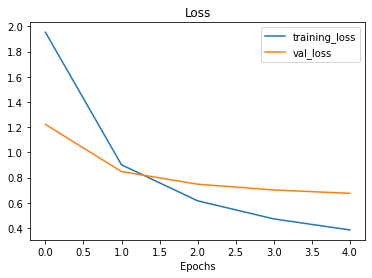

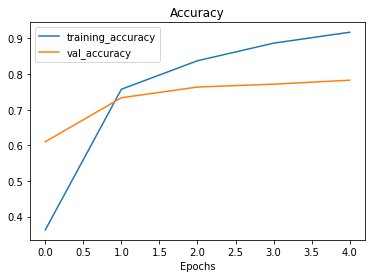

In [21]:
plot_loss_curves(resnet_history)

In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


TensorFlow Hub'ın gücünü burada görebilirsiniz. Özellik çıkarma katmanı, modelin ImageNet veri kümesinde önceden öğrenmiş olduğu önceden öğrenilmiş desenler olan 23.564.800 parametreye sahiptir. Trainable=False ayarını yaptığımız için, bu modeller eğitim sırasında donmuş (eğitilemez) olarak kalır.

Bu, eğitim sırasında modelin çıktı katmanındaki 20.490 parametreyi veri kümemize uyacak şekilde güncellediği anlamına gelir.

Tamam, bir ResNetV250 modelini eğittik, aynısını EfficientNetB0 modeliyle yapmanın zamanı geldi.

`create_model()` işlevindeki model_url parametresi ve `create_tensorboard_callback()` işlevindeki `trial_name` parametresi dışında kurulum öncekiyle tamamen aynı olacaktır.

In [23]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent, 
                                              epochs=5, 
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     experiment_name="efficientnetB0")])

TensorBoard günlük dosyalarını kaydetme: tensorflow_hub/efficientnetB0/20210718-072739
Epoch 1/5
24/24 [==============================] - 26s 784ms/step - loss: 1.8246 - accuracy: 0.4560 - val_loss: 1.2880 - val_accuracy: 0.7260
Epoch 2/5
24/24 [==============================] - 15s 626ms/step - loss: 1.0520 - accuracy: 0.7760 - val_loss: 0.8606 - val_accuracy: 0.8164
Epoch 3/5
24/24 [==============================] - 15s 656ms/step - loss: 0.7489 - accuracy: 0.8333 - val_loss: 0.6961 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 16s 666ms/step - loss: 0.6025 - accuracy: 0.8587 - val_loss: 0.6101 - val_accuracy: 0.8576
Epoch 5/5
24/24 [==============================] - 15s 634ms/step - loss: 0.5112 - accuracy: 0.8947 - val_loss: 0.5553 - val_accuracy: 0.8648


`EfficientNetB0` modeli, `ResNetV250` modelinden bile daha iyi bir sonuç verdi! Yine eğitim verilerinin yalnızca %10'u ile test setinde %85'in üzerinde doğruluk elde etmek. Ne kadar havalı değil mi?

Birkaç satır kodla, son teknoloji modellerden yararlanabiliyor ve bunları kendi kullanım durumumuza göre ayarlayabiliyoruz.

Kayıp (Loss) eğrilerini kontrol edelim.

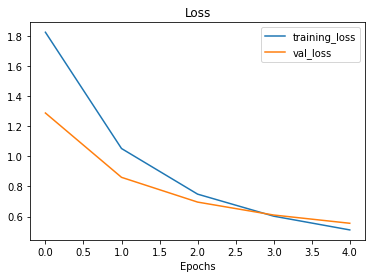

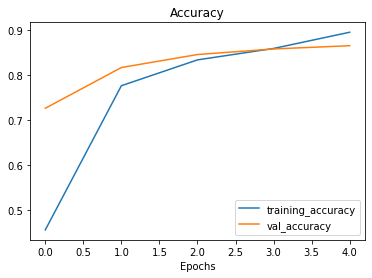

In [24]:
plot_loss_curves(efficientnet_history)

EfficientNetB0 modelinin kayıp eğrilerine bakıldığında, modelimizi daha uzun süre eğitmeye devam edersek, daha da gelişebilir gibi görünüyor. Belki de denemek isteyebileceğiniz bir şeydir?

Model özetini kontrol edelim.

In [25]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


ResNet50V2 çıkarma katmanından dört kat daha az parametreye (4.049.564'e karşı 23.564.800) sahip olmasına rağmen, EfficientNetB0 özellik çıkarma katmanı daha iyi performans sağlıyor gibi görünüyor. Şimdi "verimli(efficient)" ismin nereden geldiği açığa kavuştu.

## TensorBoard Kullanarak Modelleri Karşılaştırma

Pekala, doğruluk puanlarına bakarak iki modelimizin performansını zaten karşılaştırmış olmamıza rağmen. Peki ya ikiden fazla modeliniz varsa?

TensorBoard (Google Colab'a önceden yüklenmiş) gibi bir deneme izleme aracının devreye girdiği yer burasıdır.

İşin iyi yanı, bir TensorBoard geri araması oluşturduğumuzdan, modelimizin tüm eğitim günlükleri otomatik olarak kaydedildi. Bunları görselleştirmek için sonuçları TensorBoard.dev'e yükleyebiliriz.

Sonuçlarınızı TensorBoard.dev'e yüklemek, birden çok farklı modelleme deneyini izlemenize ve paylaşmanıza olanak tanır. Dolayısıyla, sonuçlarınızı birine göstermeniz gerekirse, onlara TensorBoard.dev'inize ve beraberindeki Colab not defterine bir bağlantı gönderebilirsiniz.

> 🔑 Not: Bu deneyler herkese açıktır, hassas verileri yüklemeyin. Gerekirse deneyleri silebilirsiniz.

TensorBoard'a bir dizi TensorFlow günlüğü yüklemek için aşağıdaki komutu kullanabiliriz:

```
!tensorboard dev upload --logdir ./tensorflow_hub/ \ upload directory
  --name "EfficientNetB0 vs. ResNet50V2" \ 
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \ 
  --one_shot
```

- **--logdir** hedef yükleme dizinidir
- **--name** deneyin adıdır
- **--description**, deneyin kısa bir açıklamasıdır
- **--one_shot**, yükleme tamamlandığında TensorBoard yükleyicisinden çıkar

Tensorboard dev yükleme komutunu çalıştırmak, önce sizden TensorBoard.dev'e yüklemeyi yetkilendirmenizi isteyecektir. Yüklemeye yetki verdikten sonra günlük dosyalarınız yüklenecektir.

In [27]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Eğitim görüntülerinin %10'unu kullanarak iki farklı TF Hub özellik çıkarma modeli mimarisini karşılaştırma" \
  --one_shot

2021-07-18 07:32:27.365995: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

Aynı dizini tekrar yüklerseniz, onunla birlikte kullanabileceğiniz yeni bir deneme kimliği alırsınız.

Bu, denemelerinizi izlemek için yüklemelerinizi nasıl adlandırdığınıza bakmak isteyebilirsiniz. Bu şekilde, onları TensorBoard.dev'de bulduğunuzda, her deney sırasında ne olduğunu anlayabilirsiniz (örneğin, "efficientNet0_10_percent_data").

Yüklediğiniz tüm deneyleri görmek için şu komutu kullanabilirsiniz:

In [28]:
!tensorboard dev list

2021-07-18 07:33:48.244992: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/8GMyPMx6Q8i6PWKxlobOUA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Eğitim görüntülerinin %10'unu kullanarak iki farklı TF Hub özellik çıkarma modeli mimarisini karşılaştırma
	Id                   8GMyPMx6Q8i6PWKxlobOUA
	Created              2021-07-18 07:32:52 (1 minute ago)
	Updated              2021-07-18 07:32:54 (1 minute ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  6086643
https://tensorboard.dev/experiment/i2nAxQRWTdi5SaO8AGLEyQ/
	Name                 Transfer learning experiments
	Description          A s

<img src="https://i.ibb.co/bKLwqgv/Screenshot-from-2021-07-18-10-34-59.png" />

Unutmayın, TensorBoard.dev'e yapılan tüm yüklemeler herkese açıktır, bu nedenle bir deneyi silmek için şu komutu kullanabilirsiniz:

`tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]`

In [30]:
# Delete an experiment
!tensorboard dev delete --experiment_id 8GMyPMx6Q8i6PWKxlobOUA

2021-07-18 07:37:06.957170: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Deleted experiment 8GMyPMx6Q8i6PWKxlobOUA.


In [31]:
# hala var olup olmadığını kontrol edin
!tensorboard dev list

2021-07-18 07:37:31.456131: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
No experiments. Use `tensorboard dev upload` to get started.
